# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

from text_classification.fast_text.train import trainIters

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

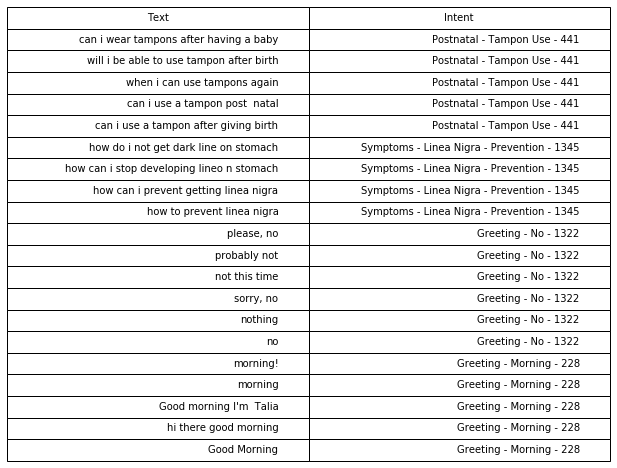

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

In [7]:
import torch
torch.__version__

'0.4.0a0+5463a4a'

Start training the classification model and save

In [8]:
training_data = [(item, y_train[idx]) for idx, item in enumerate(X_train)]

losses, model = trainIters(training_data, 
                           classes, 
                           n_iters=100, 
                           log_every=5, 
                           verbose=1, 
                           learning_rate=1e-3, 
                           batch_size=64)

Training started
Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
0m 36s (- 11m 39s) (5 5%) 0.1113 - accuracy: 0.0104
1m 49s (- 16m 21s) (10 10%) 0.0831 - accuracy: 0.1365
2m 38s (- 14m 57s) (15 15%) 0.0478 - accuracy: 0.4242
3m 22s (- 13m 30s) (20 20%) 0.0278 - accuracy: 0.6355
3m 53s (- 11m 40s) (25 25%) 0.0178 - accuracy: 0.7543
4m 35s (- 10m 42s) (30 30%) 0.0124 - accuracy: 0.8227
5m 52s (- 10m 55s) (35 35%) 0.0091 - accuracy: 0.8642
6m 29s (- 9m 43s) (40 40%) 0.0071 - accuracy: 0.8898
7m 8s (- 8m 43s) (45 45%) 0.0058 - accuracy: 0.9067
7m 36s (- 7m 36s) (50 50%) 0.0049 - accuracy: 0.9182
8m 3s (- 6m 35s) (55 55%) 0.0042 - accuracy: 0.9268
8m 29s (- 5m 39s) (60 60%) 0.0038 - accuracy: 0.9329
8m 55s (- 4m 48s) (65 65%) 0.0034 - accuracy: 0.9374
9m 21s (- 4m 0s) (70 70%) 0.0032 - accuracy: 0.9411
9m 47s (- 3m 15s) (75 75%) 0.0030 - accuracy: 0.9440
10m 12s (- 2m 33s) (80 80%) 0.0028 - accuracy: 0.9461
10m 38s (- 1m 52s) (85 85%) 0.0027 - accuracy: 0.

In [9]:
print(model.temperature.item())

1.2732374668121338


Plot the losses graph (this helps choosing number of epochs and learning rate)

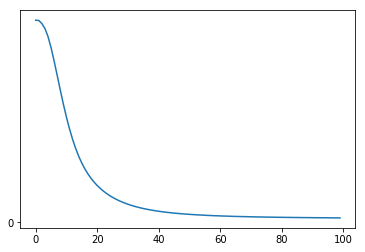

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=5)
ax.yaxis.set_major_locator(loc)
plt.plot(losses)

Test the trained model

In [12]:
from text_classification.fast_text.predict import predict
TEST_SENTENCE = 'good morning!'

with torch.no_grad():
    scores = model([TEST_SENTENCE], True)
    topk_scores, topk_idx = torch.topk(scores, 5)
    print(topk_scores[0,0])
    print(classes[topk_idx[0,0].item()])

[[-1]]

-0
[torch.FloatTensor of size ()]

Diet - How Much - First
